<a href="https://colab.research.google.com/github/kevin-vmi/AI-Deep-Learning-Lab-2021/blob/mednist_kevin/sessions/mednist-monai/MedNIST_Classification_MONAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MedNIST Exam Classification with MONAI

Welcome to the RSNA2021 deep learning lab!

In this notebook, we perform a classification training with MONAI on the MedNIST dataset. Learning objectives:

* Create a MONAI Dataset to pre-process data with MONAI tranforms.
* Train a DenseNet model with MONAI and PyTorch frameworks.
* Evaluate on test dataset.

<img src='https://drive.google.com/uc?export=download&id=1ow_D-LJY6kD6n-r3x047yHbFJcDiBws3' width='500'/>

###Using Jupyter notebook:
Simply press `Shift+Enter` to run the cell. Code can be stopped by choosing in the list of "Runtime". 
 
_______________________________________________________________________________

###Part 0: Install packages and get the dataset 


In [2]:
# Install MONAI

!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 699 kB 5.2 MB/s 
     |████████████████████████████████| 54.5 MB 49 kB/s 
     |████████████████████████████████| 15.0 MB 906 kB/s 
     |████████████████████████████████| 20.3 MB 11.4 MB/s 
     |████████████████████████████████| 95.3 MB 1.4 MB/s 
     |████████████████████████████████| 16.6 MB 33.8 MB/s 
     |████████████████████████████████| 70.6 MB 9.0 kB/s 


In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 0.8.dev2147
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 356ba3f25350e785387113684d6d2f4317a0f458

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



The MedNIST dataset was gathered from several sets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. 

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic).

In [4]:
# download the data from google drive. 
!wget -q https://www.dropbox.com/s/pwir62kkz4n7dsq/MedNIST.tar

In [5]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar")
datafile.extractall()
datafile.close()

There are 6 folders in the dataset: 

0: "Hand", 

1: "AbdomenCT",

2: "CXR",

3: "ChestCT",

4: "BreastMRI",

5: "HeadCT", 

which should be used as the labels to train our classification model.

In [ ]:
#@title Some exercise on showing the directory and folders.

#The current directory?
os.getcwd()
#List the folder names under the data folder?
os.listdir('MedNIST')

Make sure GPU is available:

In [7]:
if torch.cuda.is_available() == False:
    print("Warning: CUDA not found, CPU only.") 
else:
    print ("GPU is connected.")      


GPU is connected.


In [8]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[1000]).size


In [ ]:
#@title Some exercises to print the variables for a better understanding on the cell above.

# What is class_names?
print("Label names:", class_names)
# How many images do we have in total?
print("Total image count:", num_total)
# How about the number of images in each class?
print ("Label counts:", [len(image_files[i]) for i in range(num_class)])
# What is the image size for each slice?
print ("Image dimensions:", image_width, "x", image_height)

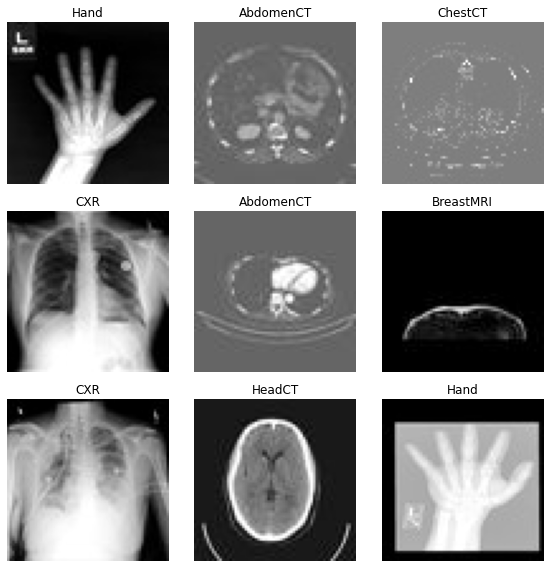

In [99]:
# Visualize some examples from the dataset
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.title(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
#@title Some exercise about the plot, e.g., np.random.randint, and seed. 

plt.subplots(3, 3, figsize=(8, 8))
np.random.seed(10)
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.title(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

_______________________________________________________________________________

###Part 1: Create training, validation and test datasets, and pre-process data with MONAI. 

We move on to partioning the data into three datasets:

* Training dataset is used to minimize the loss function (80%);
* Validation dataset may be used to modify the hyperparameters (10%);
* Testing dataset is created for final evaluation once the training is completed (10%).  




In [11]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

np.random.seed(0)
for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 46946 Validation count = 6022 Test count = 5986


In [ ]:
#@title Exercise on data partitioning. 

# What is the actual ratio of each dataset? 
# Are they exactly equal to 0.8, 0.1 and 0.1?
print (len(trainX)/num_total, len(valX)/num_total,len(testX)/num_total)

In [ ]:
#@title Another approach to partition the data into training, validation, and test datasets. 
seed = 44
file_list  = image_file_list[:]
label_list = image_label_list[:]
np.random.seed(seed)
np.random.shuffle(file_list)
np.random.seed(seed)
np.random.shuffle(label_list)

train_ratio = 0.8
val_ratio = 0.1

num_train = int(train_ratio*num_total)
num_val   = int(val_ratio*num_total)

trainX, trainY = file_list[0:num_train],label_list[0:num_train]
valX, valY = file_list[num_train : num_train + num_val], label_list[num_train : num_train + num_val]
testX, testY = file_list[num_train + num_val:], label_list[num_train + num_val:]

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))


Define MONAI transforms. (show examples, why we need to use MONAI, explain more for each augmentation operations.)

In [16]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class, n_classes=num_class)

In [ ]:
#@title Practice on MONAI transforms: LoadImage()

ex = image_file_list[10]
print ('example image address:', ex)
image = LoadImage(image_only = True)(ex)
print (image.shape) 

plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('LoadImage')
plt.imshow(image.transpose(), cmap='gray', vmin=0, vmax=255)

im = Image.open(ex)
arr = np.array(im)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('LoadImage')
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

print("MONAI automatically choose readers based on the supported suffixes.")
print("Default readers: (nii, nii.gz -> NibabelReader), (png, jpg, bmp -> PILReader), (npz, npy -> NumpyReader), (others -> ITKReader).")

In [ ]:
#@title Practice on MONAI transforms: AddChannel()

ex = image_file_list[10]
print ('example image address:', ex)
image = LoadImage(image_only = True)(ex)
print ("Before applying AddChannel:",image.shape)

image_1 = AddChannel()(image)
print ("After applying AddChannel:",image_1.shape)

print("AddChannel convert the image into the channel_first format.")


In [ ]:
#@title Practice on MONAI transforms: ScaleIntensity()
ex = image_file_list[10]
print ('example image address:', ex)
image = LoadImage(image_only = True)(ex)
image = AddChannel()(image)
print ("Before applying AddChannel:",image.shape)
print ("The min:", np.min(image),"The max:", np.max(image))

print("Apply ScaleIntensity()")
image_1 = ScaleIntensity() (image)
print ("The min:", np.min(image_1),"The max:", np.max(image_1))

In [ ]:
#@title Practice on MONAI transforms: RandRotate()

ex = image_file_list[1000]
print ('example image address:', ex)
image = LoadImage(image_only = True)(ex)
image = AddChannel()(image)
print (image.shape) 

plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('LoadImage')
plt.imshow(image[0,].transpose(), cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('LoadImage')
image_1 = RandRotate(range_x=15, prob=0.5, keep_size=True) (image)
plt.imshow(image_1[0,].transpose(), cmap='gray', vmin=0, vmax=255)
plt.show()

print ("range_x: Range of rotation angle in radians in the plane.")
print ("If single number, angle is uniformly sampled from (-range_x, range_x).")

In [ ]:
#@title Practice on MONAI transforms: RandFlip()

ex = image_file_list[1000]
print ('example image address:', ex)
image = LoadImage(image_only = True)(ex)
image = AddChannel()(image)
print (image.shape) 

plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('LoadImage')
plt.imshow(image[0,].transpose(), cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('LoadImage')
image_1 = RandFlip(spatial_axis=0, prob=0.5) (image)
plt.imshow(image_1[0,].transpose(), cmap='gray', vmin=0, vmax=255)
plt.show()


In [ ]:
#@title Practice on MONAI transforms: RandZoom()

ex = image_file_list[1000]
print ('example image address:', ex)
image = LoadImage(image_only = True)(ex)
image = AddChannel()(image)
print (image.shape) 

plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('LoadImage')
plt.imshow(image[0,].transpose(), cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('LoadImage')
image_1 = RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True)(image)
plt.imshow(image_1[0,].transpose(), cmap='gray', vmin=0, vmax=255)
plt.show()


In [ ]:
#@title Practice on MONAI transforms: ToTensor()

ex = image_file_list[10]
print ('example image address:', ex)
image = LoadImage(image_only = True)(ex)
image = AddChannel()(image)
print ("Before applying ToTensor:",type(image))

image_1 = ToTensor()(image)
print ("After applying ToTensor:",type(image_1))

print("ToTensor() converts the numpy array into the torch tensor format.")


Build Dataset and Dataloader (use the defined function "train_transforms" for augmentations). 

In [94]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

In [ ]:
#@title Exercise on Dataset and Dataloader

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print (type(images), type(labels))
print(images.shape)
print (labels)



_______________________________________________________________________________

###Part 2: Define the model and perform the training.  


In [95]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 4
val_interval = 1

In [96]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.9051
2/157, train_loss: 1.8998
3/157, train_loss: 1.8825
4/157, train_loss: 1.8456
5/157, train_loss: 1.8014
6/157, train_loss: 1.7709
7/157, train_loss: 1.7604
8/157, train_loss: 1.7619
9/157, train_loss: 1.7221
10/157, train_loss: 1.7084
11/157, train_loss: 1.6441
12/157, train_loss: 1.6358
13/157, train_loss: 1.6222
14/157, train_loss: 1.5791
15/157, train_loss: 1.5521
16/157, train_loss: 1.5399
17/157, train_loss: 1.5524
18/157, train_loss: 1.5172
19/157, train_loss: 1.4938
20/157, train_loss: 1.4736
21/157, train_loss: 1.4586
22/157, train_loss: 1.4371
23/157, train_loss: 1.3863
24/157, train_loss: 1.4187
25/157, train_loss: 1.4296
26/157, train_loss: 1.3426
27/157, train_loss: 1.3630
28/157, train_loss: 1.3605
29/157, train_loss: 1.2792
30/157, train_loss: 1.3330
31/157, train_loss: 1.2961
32/157, train_loss: 1.2576
33/157, train_loss: 1.2690
34/157, train_loss: 1.2353
35/157, train_loss: 1.2106
36/157, train_loss: 1.1820
37/157, train_lo

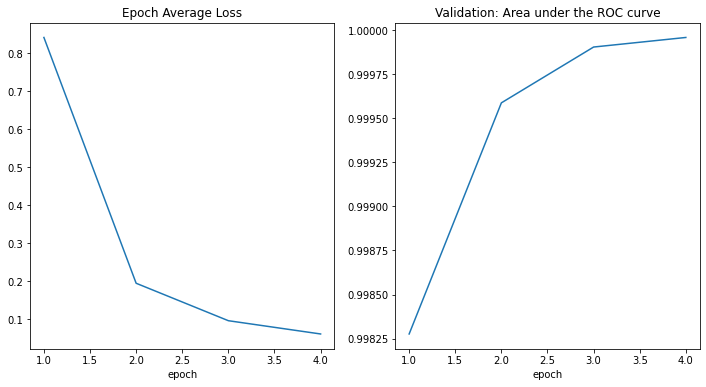

In [97]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

_______________________________________________________________________________

###Part 3: Evaluate the best-metric model on the test dataset.  


In [98]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9884    0.9843    0.9864       955
   BreastMRI     0.9989    0.9822    0.9905       901
         CXR     0.9980    0.9912    0.9946      1017
     ChestCT     0.9911    1.0000    0.9955      1005
        Hand     0.9902    0.9967    0.9935       915
      HeadCT     0.9880    0.9990    0.9935       992

    accuracy                         0.9924      5785
   macro avg     0.9925    0.9922    0.9923      5785
weighted avg     0.9924    0.9924    0.9924      5785

